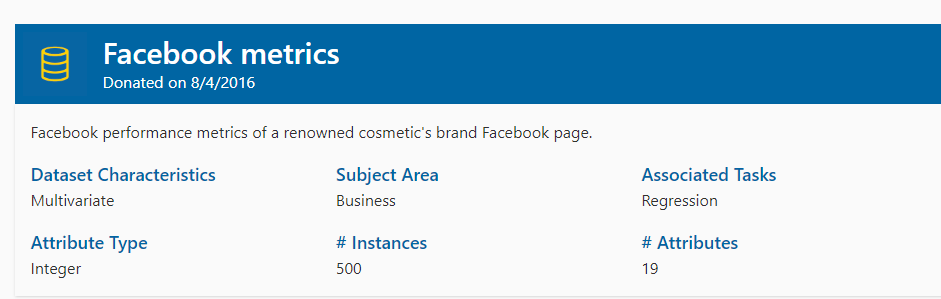

    

## Objectives

After completing this lab you will be able to:

* Use scikit-learn to implement Multiple Linear Regression
* Create a model, train it, test it and use the model


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#understanding-data">Understanding the Data</a></li>
        <li><a href="#reading_data">Reading the Data in</a></li>
        <li><a href="#multiple_regression_model">Multiple Regression Model</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


### Importing Needed packages


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

# metrics 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


<h2 id="understanding_data">Understanding the Data</h2>

### `dataset_Facebook.csv`:
The data is related to posts' published during the year of 2014 on the Facebook's page of a renowned cosmetics brand.
This dataset contains 500 of the 790 rows and part of the features analyzed by Moro et al. (2016). The remaining were omitted due to confidentiality issues. [Dataset source](https://archive.ics.uci.edu/dataset/368/facebook+metrics)

<h2 id="reading_data">Reading the data in</h2>


In [2]:
df = pd.read_csv('dataset_Facebook.csv')

# take a look at the dataset
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [3]:
# data shape
df.shape

(500, 19)

In [4]:
# misssing values
df.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [5]:
# drop missing values
df_new = df.dropna()

In [6]:
# check the df_new for any missing values
df_new.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

### Let's select some features that we want to use for regression.


In [7]:
# create a list of subset features for the first 7 konw to predict the Total interactions
features = ['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid']

The above features are known prior to the post publication, and our goal is to predict the Total interactions.

In [8]:
# full features
full_features = df.columns.tolist()[:18] 
print('List of full features: ', full_features)

List of full features:  ['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid', 'Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Lifetime Engaged Users', 'Lifetime Post Consumers', 'Lifetime Post Consumptions', 'Lifetime Post Impressions by people who have liked your Page', 'Lifetime Post reach by people who like your Page', 'Lifetime People who have liked your Page and engaged with your post', 'comment', 'like', 'share']


### Now let's plot a correlation matrix to see if there's any multicolinearity.

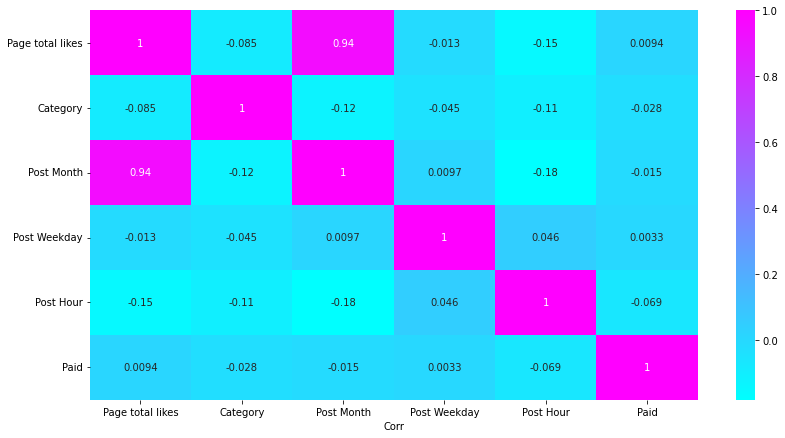

In [9]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(df_new[features].corr(), annot=True,cmap=plt.cm.cool)
plt.tight_layout()
plt.xlabel('Corr')
plt.show()

**Note:** if you take a look at the correlation matrix plot you'll find out that there's is strong correlation between 'past month' and 'page total likes', however we will leave for now.

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  __np.random.rand()__ function: 


In [10]:
# new subset dataframe abbrevation of facebook metrics df
fmdf = df_new.copy()
fmdf.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


### Let us lebal encode the Type column 

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
fmdf['Type'] = le.fit_transform(fmdf['Type'])
fmdf.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [12]:
# now randomly split the dataset into 80% training and 20% testing
msk = np.random.rand(len(df_new[features])) < 0.8
train = fmdf[msk]
test = fmdf[~msk]

### Assign to target and input:

In [13]:
x = np.asanyarray(train[features])
y = np.asanyarray(train[['Total Interactions']])

<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In [14]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (x, y)

LinearRegression()

### Metrics:

In [15]:
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 4.19912851e-03  2.33778060e+01  5.07488892e+01 -1.45711808e+01
  -1.80055356e+01  9.87723638e-01  1.10282403e+02]]


As mentioned before, __Coefficient__ and __Intercept__  are the parameters of the fitted line. 
Given that it is a multiple linear regression model with 7 parameters and that the parameters are the intercept and coefficients of the hyperplane, sklearn can estimate them from our data. Scikit-learn uses plain Ordinary Least Squares method to solve this problem.

#### Ordinary Least Squares (OLS)
OLS is a method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by minimizing the sum of the squares of the differences between the target dependent variable and those predicted by the linear function. In other words, it tries to minimizes the sum of squared errors (SSE) or mean squared error (MSE) between the target variable (y) and our predicted output ($\hat{y}$) over all samples in the dataset.

OLS can find the best parameters using of the following methods:
* Solving the model parameters analytically using closed-form equations
* Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)


<h2 id="prediction">Prediction</h2>


In [16]:
y_hat= regr.predict(test[features])
x = np.asanyarray(test[features])
y = np.asanyarray(test[['Total Interactions']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 37552.95
Variance score: 0.01


### R square, Adjusted R_square, RMSE, MSE:

In [17]:
R_2 = r2_score(y, y_hat)
Adj_r2 = 1-(1-R_2)*(len(df_new)-1)/(len(df_new)-18-1)
#n = count of rows in your dataset used for train or test
#p = count of independent variables
mse = mean_squared_error(y, y_hat)
rmse = (mean_squared_error(y, y_hat))**0.5

In [18]:
print("R_square: ", R_2)
print("Adj R_square: ", Adj_r2)
print("MSE:", mse)
print("RMSE:", rmse)

R_square:  0.005311501347609382
Adj R_square:  -0.032302769609833915
MSE: 37552.95406642194
RMSE: 193.78584588772716


__Explained variance regression score:__  
Let $\hat{y}$ be the estimated target output, y the corresponding (correct) target output, and Var be the Variance (the square of the standard deviation). Then the explained variance is estimated as follows:

$\texttt{explainedVariance}(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}}$  
The best possible score is 1.0, the lower values are worse.


<h2 id="practice">Practice</h2>
 Use the full_features list of input variable to see if the result is better accuracy?


In [19]:
# instantiate the model
regr = linear_model.LinearRegression()

# assing the dependent/inputs and independent/output 
x = np.asanyarray(train[features])
y = np.asanyarray(train[['Total Interactions']])

# fit the model
regr.fit (x, y)

# print the coefficients
print ('Coefficients: ', regr.coef_)

# the yhat (predict y-variables)
y_= regr.predict(test[features])

# assign the x and y value for variance score evaluation
x = np.asanyarray(test[features])
y = np.asanyarray(test[['Total Interactions']])

print("Residual sum of squares: %.2f"% np.mean((y_ - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[ 4.97861163e-03  2.05646788e+01  5.79924981e+01 -2.02351726e+01
  -1.47282166e+01  2.10193200e+00  1.05090080e+02]]
Residual sum of squares: 55930.42
Variance score: -0.06


### Metrics

In [20]:
R_2 = r2_score(y, y_)
Adj_r2 = 1-(1-R_2)*(len(df_new)-1)/(len(df_new)-18-1)
#n = count of rows in your dataset used for train or test
#p = count of independent variables
mse = mean_squared_error(y, y_)
rmse = (mean_squared_error(y, y_))**0.5

In [21]:
print("R_square: ", R_2)
print("Adj R_square: ", Adj_r2)
print("MSE:", mse)
print("RMSE:", rmse)

R_square:  -0.057773754293877655
Adj R_square:  -0.09777360214532682
MSE: 55930.42237879119
RMSE: 236.49613607581665


<details><summary><h3>Click here for the solution</h3></summary>

```python

# instantiate the model
regr = linear_model.LinearRegression()

# assing the dependent/inputs and independent/output 
x = np.asanyarray(train[full_features])
y = np.asanyarray(train[['Total Interactions']])

# fit the model
regr.fit (x, y)

# print the coefficients
print ('Coefficients: ', regr.coef_)

# the yhat (predict y-variables)
y_= regr.predict(test[full_features])

# assign the x and y value for variance score evaluation
x = np.asanyarray(test[full_features])
y = np.asanyarray(test[['Total Interactions']])

print("Residual sum of squares: %.2f"% np.mean((y_ - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))
    


```

</details>